In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
from statistics import mean
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

# 
df1 = pd.read_csv('raw_data/formal_4_12.csv')
df2 = pd.read_csv('raw_data/formal2_4_19.csv')
df3 = pd.read_csv('raw_data/formal3_4_25.csv')
df4 = pd.read_csv('raw_data/formal4_4_26.csv')

df_all = pd.concat([df1, df2, df3, df4])

# filter out records that are missing any 'progress quizzes'
df_all = df_all.dropna(subset=['q1progress', 'q2progress', 'q3progress'])
# drop duplicates if there are any
df_all = df_all.drop_duplicates(subset='code', keep="last")

df = df_all
df.head()

,code,interface,interfaceorder,completionthreequizzes,completionall,test1,test2,q1date,q1time,q1progress,...,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17
0,B-second-third-first-6d738282-a62b-4567-8797-1...,B,second-third-first,Yes,Yes,13,40,2021-04-10-18:32:07,3:29,75,...,3.0,3.0,1.0,2.0,3.0,4.0,4.0,Male,45–54,"No, I have never used smartwatch before"
1,I-first-second-third-67abf179-ea17-4b3f-a628-7...,I,first-second-third,Yes,Yes,20,140,2021-04-10-19:15:03,9:17,140,...,3.0,4.0,1.0,4.0,3.0,2.0,4.0,Male,35–44,"Yes, I am currently a smartwatch user"
3,A-first-second-third-de344de9-37cb-4df6-8b11-b...,A,first-second-third,Yes,Yes,18,150,2021-04-10-18:35:25,9:17,140,...,1.0,1.0,1.0,4.0,2.0,1.0,4.0,Female,Above 65,"No, I have never used smartwatch before"
4,C-second-first-third-4eff2d1b-eee1-447e-a7b8-c...,C,second-first-third,Yes,Yes,20,140,2021-04-10-19:01:13,3:04,130,...,4.0,5.0,1.0,3.0,4.0,3.0,5.0,Male,25–34,"Yes, I used to be a smartwatch user"
5,J-third-second-first-f3c32252-db1d-4850-88f0-b...,J,third-second-first,Yes,NaN,15,40,2021-04-10-18:38:40,6:38,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
### Filter out everyone who had at least one time report with 
### edit distance > 2

### Compute Levenshtein distance between two strings
def dist(str1, len1, str2, len2):
 
    # base case: empty strings (case 1)
    if len1 == 0:
        return len2
 
    if len2 == 0:
        return len1
 
    # if the last characters of the strings match (case 2)
    cost = 0 if (str1[len1 - 1] == str2[len2 - 1]) else 1
 
    return min(dist(str1, len1 - 1, str2, len2) + 1,    # deletion (case 3a))
        dist(str1, len1, str2, len2 - 1) + 1,           # insertion (case 3b))
        dist(str1, len1 - 1, str2, len2 - 1) + cost)    # substitution (case 2 + 3c)

### The correct times for each stage
correct_time = {
    'first': '9:17',
    'second': '3:29',
    'third': '6:38'
}

### extract 
df['task1_stage'] = df['code'].str.split('-').apply(lambda x: x[1])
df['task2_stage'] = df['code'].str.split('-').apply(lambda x: x[2])
df['task3_stage'] = df['code'].str.split('-').apply(lambda x: x[3])

df['task1_correct_time'] = df['task1_stage'].replace(correct_time)
df['task2_correct_time'] = df['task2_stage'].replace(correct_time)
df['task3_correct_time'] = df['task3_stage'].replace(correct_time)


df['ed1'] = df.apply(lambda row: dist(row['q1time'], 
                                      len(row['q1time']), 
                                      row['task1_correct_time'], 
                                      len(row['task1_correct_time'])), axis=1)
df['ed2'] = df.apply(lambda row: dist(row['q2time'], 
                                      len(row['q2time']), 
                                      row['task2_correct_time'], 
                                      len(row['task2_correct_time'])), axis=1)
df['ed3'] = df.apply(lambda row: dist(row['q3time'], 
                                      len(row['q3time']), 
                                      row['task3_correct_time'], 
                                      len(row['task3_correct_time'])), axis=1)


df = df[(df['ed1'] <= 2) & (df['ed2'] <= 2) & (df['ed3'] <= 2)]

df.head()

,code,interface,interfaceorder,completionthreequizzes,completionall,test1,test2,q1date,q1time,q1progress,...,s17,task1_stage,task2_stage,task3_stage,task1_correct_time,task2_correct_time,task3_correct_time,ed1,ed2,ed3
0,B-second-third-first-6d738282-a62b-4567-8797-1...,B,second-third-first,Yes,Yes,13,40,2021-04-10-18:32:07,3:29,75,...,"No, I have never used smartwatch before",second,third,first,3:29,6:38,9:17,0,0,1
1,I-first-second-third-67abf179-ea17-4b3f-a628-7...,I,first-second-third,Yes,Yes,20,140,2021-04-10-19:15:03,9:17,140,...,"Yes, I am currently a smartwatch user",first,second,third,9:17,3:29,6:38,0,0,0
6,N-first-second-third-56af072f-b319-4291-a06c-2...,N,first-second-third,Yes,Yes,20,145,2021-04-10-18:37:51,9:17,45,...,"No, I have never used smartwatch before",first,second,third,9:17,3:29,6:38,0,0,1
8,K-first-third-second-a53970e4-bdb5-4c4c-90d7-c...,K,first-third-second,Yes,Yes,20,140,2021-04-10-18:59:38,9:27,40,...,"Yes, I am currently a smartwatch user",first,third,second,9:17,6:38,3:29,1,0,0
9,K-second-first-third-a1212db7-e76f-47ae-b21c-e...,K,second-first-third,Yes,NaN,20,140,2021-04-10-18:57:44,3:29,70,...,NaN,second,first,third,3:29,9:17,6:38,0,0,0


In [27]:
### Compute the average error for each participant

correct_progress = {
    'first': 36,
    'second': 72,
    'third': 116
}

def error_for_stage(row, stage):
    if row['task1_stage'] == stage:
        return row['task1_abs_error']
    elif row['task2_stage'] == stage:
        return row['task2_abs_error']
    else:
        return row['task3_abs_error']

# use 'correct_progress' dict to look up the "correct" answer to each stage
df['task1_correct_progress'] = df['task1_stage'].replace(correct_progress)
df['task2_correct_progress'] = df['task2_stage'].replace(correct_progress)
df['task3_correct_progress'] = df['task3_stage'].replace(correct_progress)

df['task1_error'] = df['task1_correct_progress'] - df['q1progress']
df['task2_error'] = df['task2_correct_progress'] - df['q2progress']
df['task3_error'] = df['task3_correct_progress'] - df['q3progress']

df['task1_abs_error'] = abs(df['task1_error'])
df['task2_abs_error'] = abs(df['task2_error'])
df['task3_abs_error'] = abs(df['task3_error'])

df['stage1_abs_error'] = df.apply(lambda row: error_for_stage(row, 'first'), axis=1)
df['stage2_abs_error'] = df.apply(lambda row: error_for_stage(row, 'second'), axis=1)
df['stage3_abs_error'] = df.apply(lambda row: error_for_stage(row, 'third'), axis=1)

### Compute avg error including all 3 stages, as well as omitting stage 3 (progress > 100%)
df['avg_error'] = df[['stage1_abs_error', 'stage2_abs_error', 'stage3_abs_error']].mean(axis=1)
df['avg_error_sub100'] = df[['stage1_abs_error', 'stage2_abs_error']].mean(axis=1)

df.head() # not sure why there are warnings, but the data looks OK

<ipython-input-27-80d98b0e4275>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['task1_correct_progress'] = df['task1_stage'].replace(correct_progress)
<ipython-input-27-80d98b0e4275>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['task2_correct_progress'] = df['task2_stage'].replace(correct_progress)
<ipython-input-27-80d98b0e4275>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,code,interface,interfaceorder,completionthreequizzes,completionall,test1,test2,q1date,q1time,q1progress,...,task2_error,task3_error,task1_abs_error,task2_abs_error,task3_abs_error,stage1_abs_error,stage2_abs_error,stage3_abs_error,avg_error,avg_error_sub100
0,B-second-third-first-6d738282-a62b-4567-8797-1...,B,second-third-first,Yes,Yes,13,40,2021-04-10-18:32:07,3:29,75,...,106.0,-4.0,3,106.0,4.0,4.0,3.0,106.0,37.666667,3.5
1,I-first-second-third-67abf179-ea17-4b3f-a628-7...,I,first-second-third,Yes,Yes,20,140,2021-04-10-19:15:03,9:17,140,...,-103.0,76.0,104,103.0,76.0,104.0,103.0,76.0,94.333333,103.5
6,N-first-second-third-56af072f-b319-4291-a06c-2...,N,first-second-third,Yes,Yes,20,145,2021-04-10-18:37:51,9:17,45,...,-8.0,93.0,9,8.0,93.0,9.0,8.0,93.0,36.666667,8.5
8,K-first-third-second-a53970e4-bdb5-4c4c-90d7-c...,K,first-third-second,Yes,Yes,20,140,2021-04-10-18:59:38,9:27,40,...,6.0,2.0,4,6.0,2.0,4.0,2.0,6.0,4.000000,3.0
9,K-second-first-third-a1212db7-e76f-47ae-b21c-e...,K,second-first-third,Yes,NaN,20,140,2021-04-10-18:57:44,3:29,70,...,6.0,6.0,2,6.0,6.0,6.0,2.0,6.0,4.666667,4.0


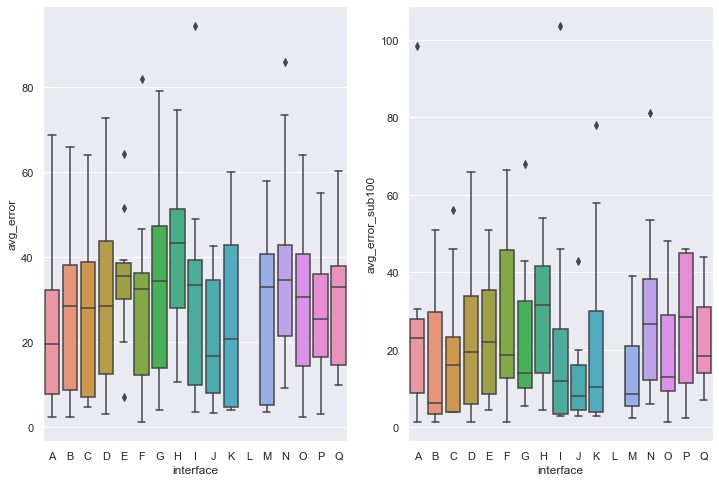

In [28]:
### Plot the average error for each interface (both overall and excluding stage 3)

letters = string.ascii_uppercase[0:17]

sns.set(rc={'figure.figsize':(12, 8)})

f, axes = plt.subplots(1, 2)
sns.boxplot(x = df['interface'], y = df['avg_error'], order=list(letters), ax=axes[0])
sns.boxplot(x = df['interface'], y = df['avg_error_sub100'], order=list(letters),ax=axes[1])
plt.show()

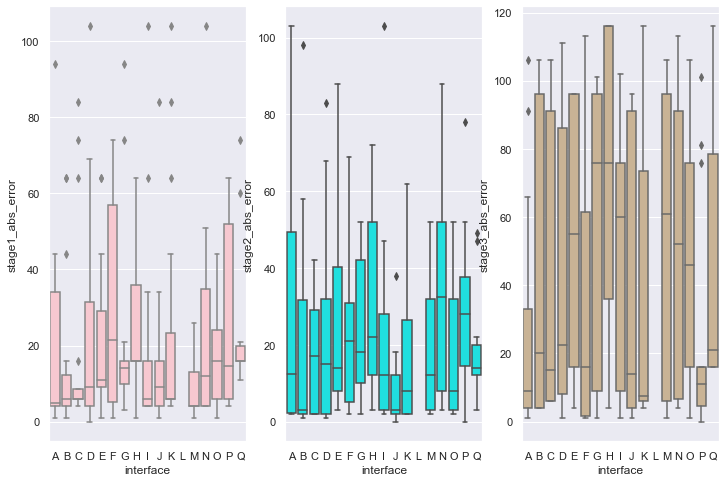

In [18]:
### Plot each stage's error independently

letters = string.ascii_uppercase[0:17]

sns.set(rc={'figure.figsize':(12, 8)})

f, axes = plt.subplots(1, 3)
sns.boxplot(x = df['interface'], y = df['stage1_abs_error'], order=list(letters), color='pink', ax=axes[0])
sns.boxplot(x = df['interface'], y = df['stage2_abs_error'], order=list(letters), color='aqua', ax=axes[1])
sns.boxplot(x = df['interface'], y = df['stage3_abs_error'], order=list(letters), color='tan', ax=axes[2])
plt.show()

In [29]:
### add columns to indicate the levels of each interface
# [salience, granularity, stylization]
# 1 = high, 0 = low

conditions = {
    'A': [1, 1, 0],
    'B': [1, 1, 0],
    'C': [1, 0, 0],
    'D': [1, 0, 0],
    
    'E': [1, 1, 1],
    'F': [0, 1, 1],
    'G': [1, 0, 1],
    'H': [0, 0, 1],

    'I': [0, 1, 0],
    'J': [0, 1, 0],
    'K': [0, 0, 0],
    'M': [0, 0, 0],
    
    'N': [0, 1, 1],
    'O': [1, 1, 1],
    'P': [0, 0, 1],
    'Q': [1, 0, 1],
}

salience = {}
granularity = {}
stylization = {}

for v in conditions.keys():
    salience[v] = conditions[v][0]
    granularity[v] = conditions[v][1]
    stylization[v] = conditions[v][2]
    
df['salience'] = df['interface'].replace(salience)
df['granularity'] = df['interface'].replace(granularity)
df['stylization'] = df['interface'].replace(stylization)
df.head()

<ipython-input-29-86377de83ea4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salience'] = df['interface'].replace(salience)
<ipython-input-29-86377de83ea4>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['granularity'] = df['interface'].replace(granularity)
<ipython-input-29-86377de83ea4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,code,interface,interfaceorder,completionthreequizzes,completionall,test1,test2,q1date,q1time,q1progress,...,task2_abs_error,task3_abs_error,stage1_abs_error,stage2_abs_error,stage3_abs_error,avg_error,avg_error_sub100,salience,granularity,stylization
0,B-second-third-first-6d738282-a62b-4567-8797-1...,B,second-third-first,Yes,Yes,13,40,2021-04-10-18:32:07,3:29,75,...,106.0,4.0,4.0,3.0,106.0,37.666667,3.5,1,1,0
1,I-first-second-third-67abf179-ea17-4b3f-a628-7...,I,first-second-third,Yes,Yes,20,140,2021-04-10-19:15:03,9:17,140,...,103.0,76.0,104.0,103.0,76.0,94.333333,103.5,0,1,0
6,N-first-second-third-56af072f-b319-4291-a06c-2...,N,first-second-third,Yes,Yes,20,145,2021-04-10-18:37:51,9:17,45,...,8.0,93.0,9.0,8.0,93.0,36.666667,8.5,0,1,1
8,K-first-third-second-a53970e4-bdb5-4c4c-90d7-c...,K,first-third-second,Yes,Yes,20,140,2021-04-10-18:59:38,9:27,40,...,6.0,2.0,4.0,2.0,6.0,4.000000,3.0,0,0,0
9,K-second-first-third-a1212db7-e76f-47ae-b21c-e...,K,second-first-third,Yes,NaN,20,140,2021-04-10-18:57:44,3:29,70,...,6.0,6.0,6.0,2.0,6.0,4.666667,4.0,0,0,0


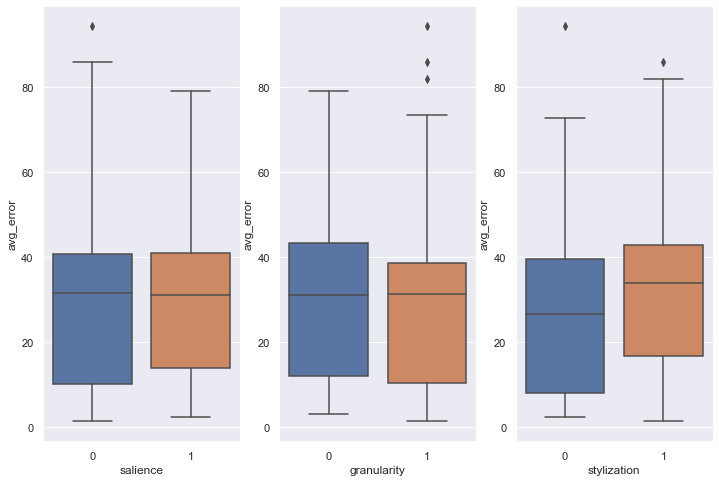

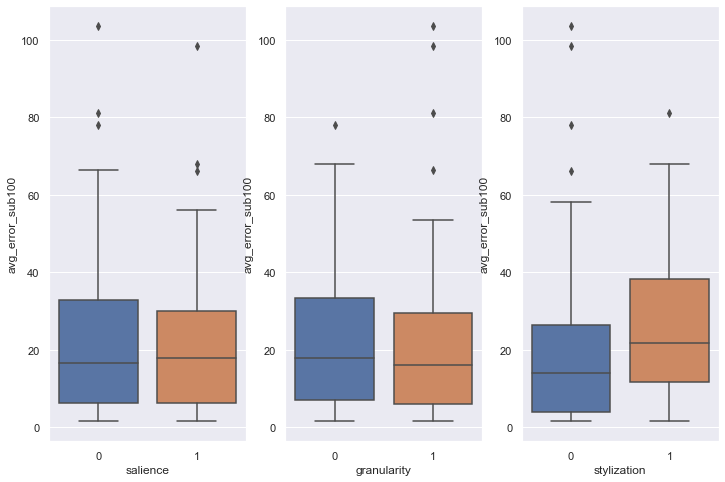

In [31]:

f, axes = plt.subplots(1, 3)
sns.boxplot(x = df['salience'], y = df['avg_error'], ax=axes[0])
sns.boxplot(x = df['granularity'], y = df['avg_error'], ax=axes[1])
sns.boxplot(x = df['stylization'], y = df['avg_error'], ax=axes[2])
plt.show()

f, axes = plt.subplots(1, 3)
sns.boxplot(x = df['salience'], y = df['avg_error_sub100'], ax=axes[0])
sns.boxplot(x = df['granularity'], y = df['avg_error_sub100'], ax=axes[1])
sns.boxplot(x = df['stylization'], y = df['avg_error_sub100'], ax=axes[2])
plt.show()
